# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2022/23 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari
---


## Lab. 03 - PyTorch regression and classification


In [81]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [82]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Practical example: Linear Regression

Now let's solve the same problem analyzed in one of the previous lab using a simple neural network implemented in PyTorch.


# Data generation

Let's generate some data with our usual polynomial model, and save the data points in two csv files, one for training (train_data.csv), and one for validation (val_data.csv).

You can find these files in the "Files" section of Colab. They are not stored in your local machine, but they are stored remotely in the Colab server.

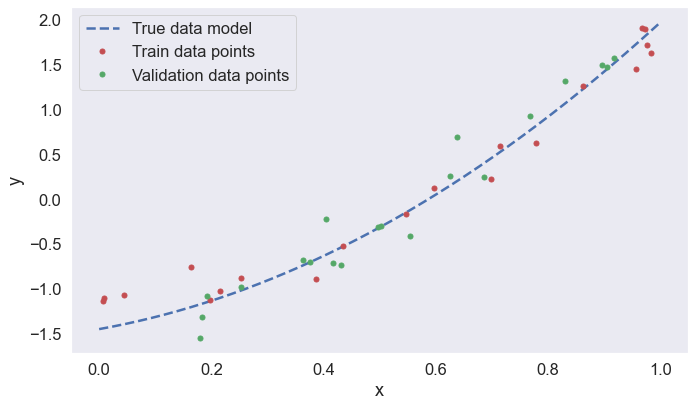

In [83]:
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

beta_true = [-1.45, 1.12, 2.3]
noise_std = 0.2
np.random.seed(4)

### Train data
num_train_points = 20
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))
    
### Validation data
num_val_points = 20
x_val = np.random.rand(num_val_points)
y_val = poly_model(x_val, beta_true, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))


### Plot
plt.figure(figsize=(10,6))
import seaborn as sns
x_highres = np.linspace(0,1,1000)
sns.set_theme (style="darkgrid", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 10})
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Network Training

## Network Definition

Define a fully connected feed-forward network with 2 hidden layers.

Use a sigmoid activation function.

Since this is a regression, we do not want to limit the value of the output. For this reason, NO activation function should be used for the output layer.

## Dataset and Dataloader


We have already implemented the dataset class in the previous lab.

### Dataset

In [84]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')

            
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### Transforms

In [85]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [86]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader

For the dataloader:

* enable the shuffling only for training data
* try different values for batch size
* disable the multiprocessing 

In [87]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

## Training loop

Now we put together all the steps analyzed in the previous lab:

In [88]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [89]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1

# Define the loss function
loss_fn = nn.MSELoss()
num_epochs = 3000

In [90]:
class RegressionNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        ###################################################
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.out = nn.Linear(Nh2, No)
        self.act = nn.Sigmoid()
        ###################################################
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

class model_regression ():
    
    def __init__(self, Ni, Nh1, Nh2, No, device):
        torch.manual_seed(0)

        self.Net = RegressionNet(Ni, Nh1, Nh2, No)
        self.Net.to(device)

    def train(self, train_dataloader, val_dataloader, loss_fn, epochs):
        self.optimizer =  optim.Adam(self.Net.parameters(), lr=1e-3)

        self.loss_fn = loss_fn

        self.train_loss_log = []
        self.val_loss_log = []

        for epoch_num in range(epochs):
            if epoch_num % 200 == 0:
                print('*'*50)
                print(f'EPOCH {epoch_num}')

            ### TRAIN
            train_loss= []
            self.Net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
            for sample_batched in train_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                ###########################################
                ### PUT YOUR CODE HERE
                out = self.Net(x_batch)

                # Compute loss
                loss = self.loss_fn(out, label_batch)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()

                # Update the weights
                self.optimizer.step()
                ###########################################

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)
        
            # Save average train loss
            train_loss = np.mean(train_loss)
            if epoch_num % 100 == 0:
                print(f"AVERAGE TRAIN LOSS: {train_loss}")
            self.train_loss_log.append(train_loss)

            ### VALIDATION
            val_loss= []
            self.Net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)

            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in val_dataloader:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    # Forward pass
                    out = self.Net(x_batch)

                    # Compute loss
                    loss = self.loss_fn(out, label_batch)

                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)


                # Save average validation loss
                val_loss = np.mean(val_loss)
                if epoch_num % 200 == 0:
                    print(f"AVERAGE VALIDATION LOSS: {val_loss}")
                self.val_loss_log.append(val_loss)

    def history(self):
        return self.train_loss_log, self.val_loss_log
    
    def plot_history(self, save_dir='.'):
        import seaborn as sns
        sns.set_theme (style="darkgrid", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 10})
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_loss_log, label='train')
        plt.plot(self.val_loss_log, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig(os.path.join(save_dir, 'loss.png'), dpi=300, bbox_inches='tight')
    
    def predict(self, x, numpy=False):
        # Network output
        # eval() acts as switch for some specific layers/parts of the model that behave
        # differently during training and inference (eval) time. For example, Dropout 
        # BatchNorm etc.  
        self.Net.eval()
        with torch.no_grad(): # turn off gradients computation
            out = self.Net(x)
        print(f"Output shape: {out.shape}")
        if numpy:
            out = out.detach().cpu().numpy()
        else:
            return out
        
    def get_weights(self, numpy=True):
        dict_weights = {}
        names = self.Net.state_dict().keys()
        print (names)
        if not numpy:
            for name in names:
                dict_weights[name] = self.Net.state_dict()[name]
        else:
            for name in names:
                dict_weights[name] = self.Net.state_dict()[name].detach().cpu().numpy()

        return dict_weights

    def save_state_dict(self, path):
        if path.split('.')[-1] != 'torch':
            path = path + '.torch'
        ### Save network parameters
        ### Save the network state
        # The state dictionary includes all the parameters of the network
        net_state_dict = self.Net.state_dict()
        print(net_state_dict.keys())
        # Save the state dict to a file
        torch.save(net_state_dict, path)

    def load_state_dict(self, path):
        if path.split('.')[-1] != 'torch':
            path = path + '.torch'
        
        # check if path exists
        if not os.path.exists(path):
            raise ValueError(f"Path {path} does not exist")

        ### Reload the network state
        # First initialize the network (if not already done)
        # Load the state dict previously saved
        net_state_dict = torch.load(path)
        # Update the network parameters
        self.Net.load_state_dict(net_state_dict)

    def save_optimizer_state(self, path):

        if path.split('.')[-1] != 'torch':
            path = path + '.torch'

        ### Save the self.optimizer state
        torch.save(self.optimizer.state_dict(), path)

    def load_optimizer_state(self, path):
        if path.split('.')[-1] != 'torch':
            path = path + '.torch'
        if not os.path.exists(path):
            raise ValueError(f"Path {path} does not exist")

        ### Reload the optimizer state
        opt_state_dict = torch.load(path)
        self.optimizer.load_state_dict(opt_state_dict)

    def get_activations (self, x, plot=True):
        
        def get_activation(layer, input, output):
            global activation
            activation = torch.sigmoid(output)

        ### Register hook  
        hook_handle = self.Net.fc2.register_forward_hook(get_activation)

        ### Analyze activations
        self.Net = self.Net.to(device)
        self.Net.eval()
        activations = []
        with torch.no_grad():
            for xx in x:
                # set to torch
                xx = torch.tensor([xx]).float()
                xx = xx.to(device)
                out = self.Net(xx)
                activations.append(activation.detach().cpu().numpy())

        print (f"Activations shape: {np.array(activations).shape}")
        ### Remove hook
        hook_handle.remove()

        if plot:
            ### Plot activations
            nplots = len (x)
            #create grid
            fig, axs = plt.subplots(nplots, 1, figsize=(15, nplots*3))
        
            for i, a in enumerate (activations):
                axs[i].stem(a, use_line_collection=True)
                axs[i].set_title('Last layer activations for input x=%.2f' % x[i])

            plt.tight_layout()
            plt.show()
        
        return activations

In [91]:
# Train the network
num_epochs = 100
model = model_regression(Ni, Nh1, Nh2, No, device)
model.train(train_dataloader, val_dataloader, loss_fn, num_epochs)

Network initialized
**************************************************
EPOCH 0
AVERAGE TRAIN LOSS: 1.5145524740219116
AVERAGE VALIDATION LOSS: 0.9295748472213745


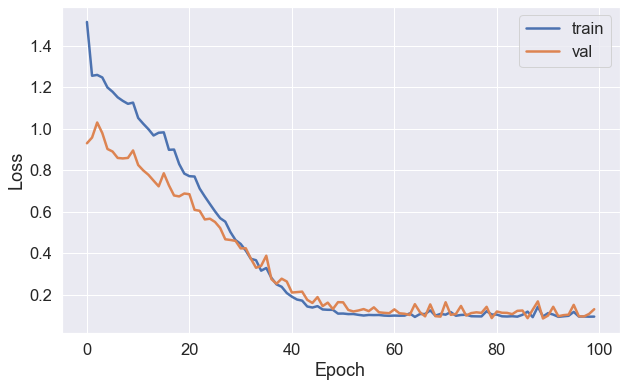

<Figure size 432x288 with 0 Axes>

In [92]:
# plot
model.plot_history()

Activations shape: (3, 256)


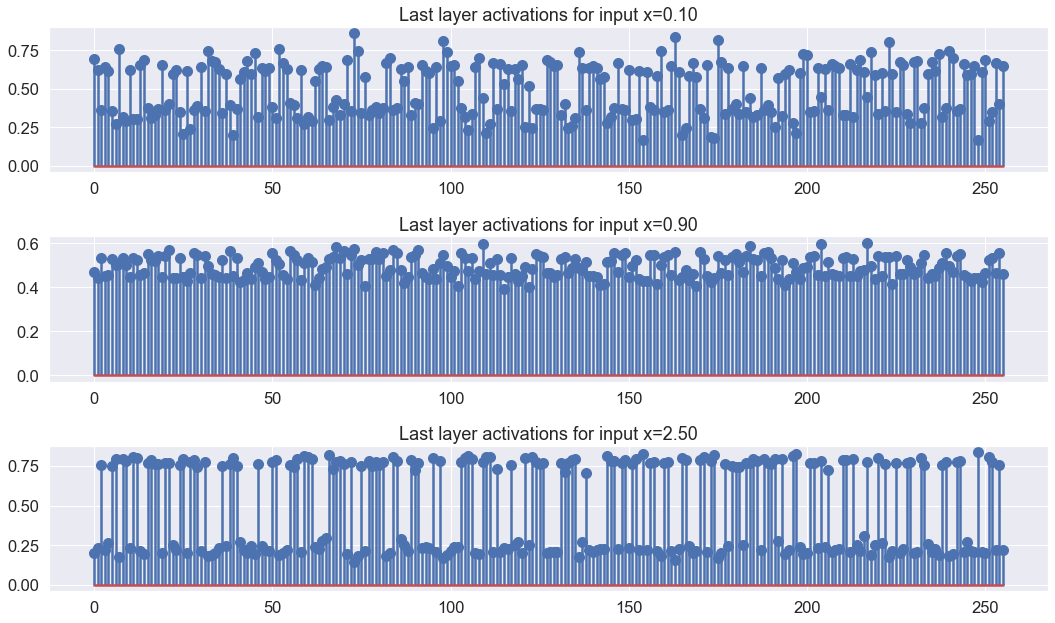

In [93]:
x = [0.1,0.9,2.5]
activations = model.get_activations(x)

# Network analysis

## Network output

In [94]:
# Input vector
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

y_vec = model.predict(x_vec)

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


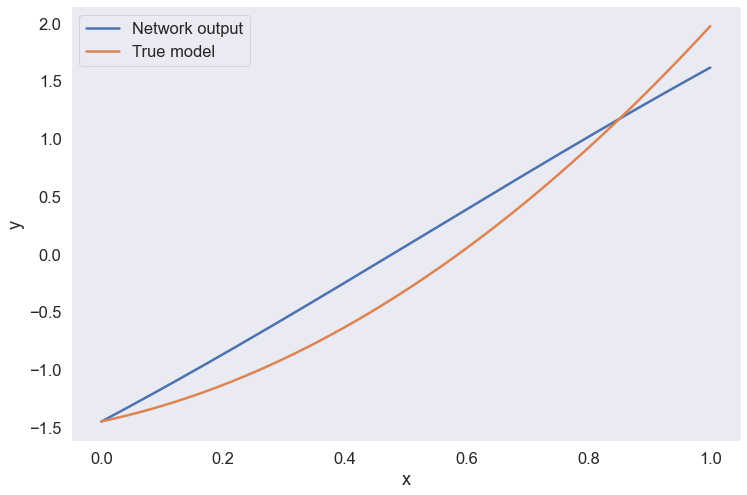

In [95]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

### What if we predict outside the range?

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


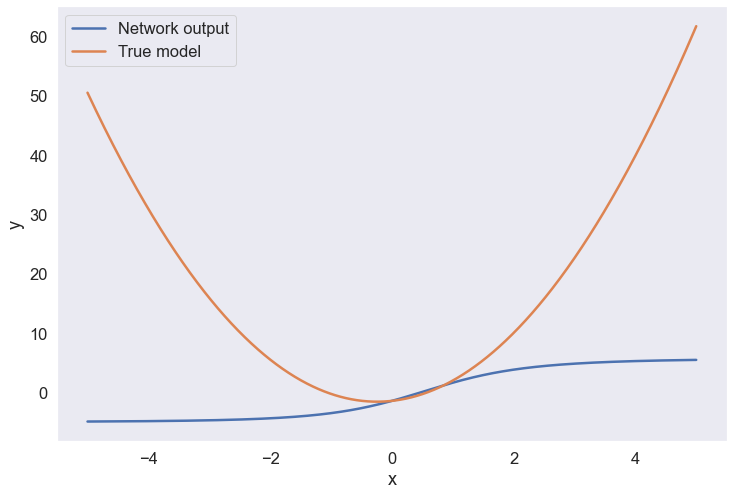

In [96]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
y_vec = model.predict(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
# y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

### What if we try different activation functions? (e.g., ReLU for nonlinearities)
### Is there overfit with ReLU?

### Homework : add some regularization to fight overfitting (e.g., dropout, weight decay,...)

## Access network parameters

In [97]:
# First hidden layer
w = model.get_weights()
h1_w = w['fc1.weight']
h1_b = w['fc1.bias']

# Second hidden layer
h2_w = w['fc2.weight']
h2_b = w['fc2.bias']

# Output layer
out_w = w['out.weight']
out_b = w['out.bias']

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])


## Weights histogram

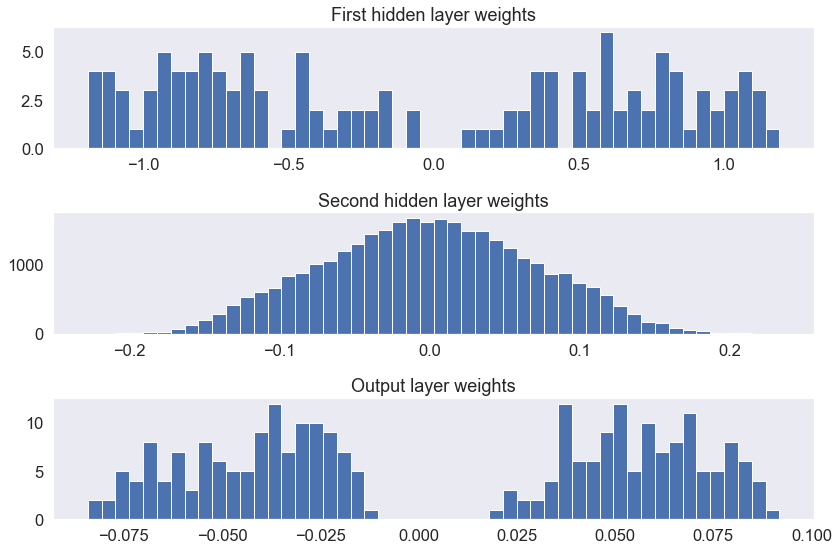

In [98]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## Save network parameters

### Save network

In [99]:
#save the model
model.save_state_dict('model')

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])


### Load network

In [100]:
model.load_state_dict('model')

## Save optimizer state
Also the optimizer has its internal state!

You need to save both the network and the optimizer states if you want to continue your training.

If you are sure you have finished your training you can just save the network.

In [101]:
model.save_optimizer_state('optimizer')
model.load_optimizer_state('optimizer')